In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
BOS, EOS = ' ', '\n'

data = pd.read_json("/Users/ivanpaseka/Downloads/arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

# if you missed the seminar, download data here - https://yadi.sk/d/_nGyU2IajjR9-w

In [62]:
# get all unique characters from lines (including capital letters and symbols)
tokens = set()
for line in lines:
    tokens |= set(line)
tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


In [64]:
token_to_id = {token: i for i, token in enumerate(tokens)}

In [66]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [68]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [70]:
#Example: cast 4 random names to a single matrix, pad with zeros where needed.
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))

[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [74]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64):
        """
        A fixed window model that looks on at least 5 previous symbols.
        """
        super().__init__()
        
        # embedding для символов
        self.emb = nn.Embedding(n_tokens, emb_size)
        
        # паддинг слева: хотим видеть 4 предыдущих + текущий (kernel_size = 5)
        self.pad = nn.ZeroPad2d((4, 0, 0, 0))   # (left, right, top, bottom)
        
        # 1D свёртка по последовательности
        self.conv = nn.Conv1d(
            in_channels=emb_size,
            out_channels=hid_size,
            kernel_size=5,
            padding=0
        )
        
        # линейный слой до размерности |V|
        self.lin = nn.Linear(hid_size, n_tokens)
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
            
        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.

        """
        # YOUR CODE - apply layers, see docstring above
        
        emb = self.emb(input_ix)              # [B, L, emb]
        x = emb.permute(0, 2, 1)              # [B, emb, L]
        x = self.pad(x)                       # pad left (4 zeros)
        x = self.conv(x)                      # [B, hid, L]
        x = x.permute(0, 2, 1)                # back to [B, L, hid]
        logits = self.lin(x)                  # [B, L, n_tokens]
        return logits
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))

In [76]:
dummy_model = FixedWindowLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('emb.weight', 'conv.weight', 'conv.bias', 'lin.weight', 'lin.bias')


In [78]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"


In [80]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = dummy_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."


In [82]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


In [84]:
def compute_loss(model, input_ix):
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64)

    logits = model(input_ix[:, :-1])           # predict next char
    ref = input_ix[:, 1:]                      # target chars

    mask = compute_mask(input_ix[:, 1:])       # mask shape = [B, L-1]
    mask = mask.to(torch.float32)

    loss_tensor = F.cross_entropy(
        logits.reshape(-1, logits.shape[-1]),
        ref.reshape(-1),
        reduction="none"
    ).reshape(ref.shape)

    loss = (loss_tensor * mask).sum() / mask.sum()
    return loss

In [86]:
loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15))
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16))
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'

In [88]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            dev_loss_num += compute_loss(model, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [90]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
model = FixedWindowLanguageModel()
opt = torch.optim.Adam(model.parameters())

# hint: if you ever wanted to switch to cuda, do it now.

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: BridgingÉ9DVvτcYGAν@cimśXC}æNJ=íN2Jf|Ł(;õ)4Qó*AÉéJ0êi]Id_Σec $êZaàó*Ö``-fő



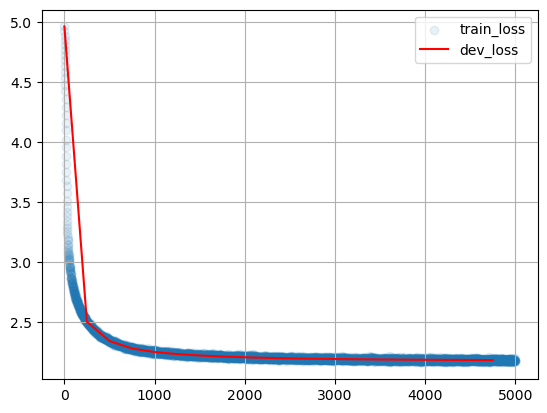

Generated examples (tau=0.5):
 Hatuce the sent on the re the sing ande-the lesing tation int ans dent unfuring ancon al wien natho 
 DASpos simalalle res ang is are mont cond comprimate conve tore the tomentich ing mane sseuting in t
 chessing the mented the detion of luthe fore the lition lapion the com utice pres count rof redentio
Scoring dev...


100%|███████████████████████████████████████| 5000/5000 [19:09<00:00,  4.35it/s]

#4999 Dev loss: 2.187


In [94]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    
    loss_i = compute_loss(model, batch)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
        
    train_history.append((i, loss_i.item()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])

In [96]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 2.1865480715588825
 Stathing ante tred tecr. Forent or complexisting thes for angens the of res question s and batid app
 ther pos and chare pared tict on expricas on the sof concons tomentin  porele the pored the sementin
 The prabe mapticis and caling and orstim tho  aplecoustion the mate tant on the deathe sed ing of di
 Learning ine the peral ing ant dentartion lestin the ing and comptome the mens for at of the rating 
 Cons an weral ors om tha ing and tor at or heve tive comply in the condin tove toble t an or proment
 A Torichis arien an the poren cor ing rolen the tion the intwerk for arneng the sele detron lapron s
 Opriction lovelation ing Conver as by ad in ares ate bed of amedet on the se for ancon the sed ches 
 Ad ons an extore thale an of cening apporachise pores ch fer nag hes pre ander se fur ure bes the ur
 Cons for the meder sethe the sernes. The seat ration preve bere the parimete tation d rechere the pr
 In the ser chis and wis luperastict of imaling

In [98]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256):
        """ 
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits
        
        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
         Also, please read the docs carefully: they don't just return what you want them to return :)
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        self.emb = nn.Embedding(n_tokens, emb_size)
        self.rnn = nn.LSTM(
        input_size=emb_size,
        hidden_size=hid_size,
        num_layers=1,
        batch_first=True)
        self.lin = nn.Linear(hid_size, n_tokens)
    
    def __call__(self, input_ix):
        emb = self.emb(input_ix)              # [B, L, emb]
        out, _ = self.rnn(emb)                # [B, L, hid]
        logits = self.lin(out)                # [B, L, n_tokens]
        return logits
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))

In [108]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256):
        super().__init__()

        self.emb = nn.Embedding(n_tokens, emb_size)
        self.rnn = nn.LSTM(
            input_size=emb_size,
            hidden_size=hid_size,
            num_layers=1,
            batch_first=True
        )
        self.lin = nn.Linear(hid_size, n_tokens)

    def __call__(self, input_ix):
        emb = self.emb(input_ix)          # [B, L, emb]
        out, _ = self.rnn(emb)            # [B, L, hid]
        logits = self.lin(out)            # [B, L, V]
        return logits

    def get_possible_next_tokens(self, prefix=BOS):
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()
        return dict(zip(tokens, probs))

In [110]:
model = RNNLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(name for name, w in model.named_parameters()))

Weights: ('emb.weight', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'lin.weight', 'lin.bias')


In [112]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

In [114]:
batch_size = 64         # <-- please tune batch size to fit your CPU/GPU configuration
score_dev_every = 250
train_history, dev_history = [], []

model = RNNLanguageModel()
opt = torch.optim.Adam(model.parameters())

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridgingνi8Iiaô.γâ<DnRm>μH5α2[Cβ(,ïS[εZZ!μlVáeνâäYAk;Σνbô7>õgQ!*Qê9õ;τzüJ[1Πjüi9AGïéRrCaOdâÖf<gΣMfub


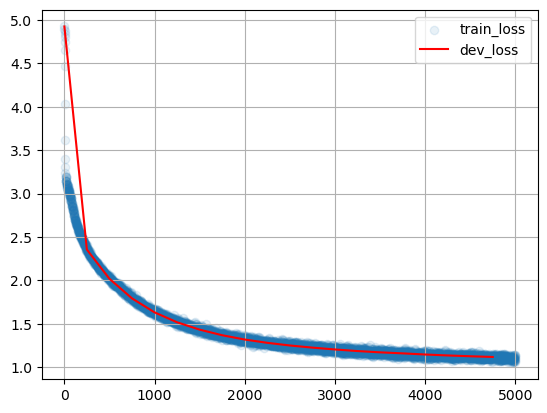

Generated examples (tau=0.5):
 Deep Learning for Semantic Descent for   Computational Framework for Sparse   Recognition ; The desc
 A Novel Contextual Semantics of Multi-Discrete Retrieval ; We propose a novel space of the shape of 
 A Minimate and Discrete Recognition ; We propose a novel methods for face images in the level of str
Scoring dev...


100%|███████████████████████████████████████| 5000/5000 [53:54<00:00,  1.55it/s]

#4999 Dev loss: 1.111


In [116]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))

    # --- один шаг обучения RNN-модели ---
    opt.zero_grad()                       # обнуляем градиенты
    loss_i = compute_loss(model, batch)   # считаем лосс
    loss_i.backward()                     # считаем градиенты
    # при желании можно включить клиппинг:
    # torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
    opt.step()                            # делаем шаг оптимизатора
    # --- конец шага обучения ---

    train_history.append((i, float(loss_i)))

    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))

    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])

In [118]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 1.110520031719673
 The Language Retrieval for Analysis of Generative Adversarial Networks ; We propose a novel methods 
 Multi-Architecture for Multilingual Solvers ; The context of spatials are interpretable measurements
 A Context of Convolutional Neural Networks ; The aim of the relation of models in this paper, we pro
 Regreterization for Multi-Speech Adversarial   Compressed Convolutional Neural Network ; The model o
 A Computational Spaces for Set of Semantic Real-Logic ; In the proposed and sparse set of the studie
 Residual Vertices with Gaussian Learning ; We propose a novel approach to train an intersect test mo
 A Convex Convolutional Neural Networks for Deep Neural Networks ; We present a general model for seq
 A Convex Matrix Structure using State-of-the-art Detection ; One of the construction of robust recog
 A Distribution of Random State-of-Parameter Semantic Descents ; We propose a new system that is a se
 Discriminative Semantics for Models ; In this p

In [120]:
def generate_nucleus(model, prefix=BOS, nucleus=0.9, max_len=100):
    """
    Generate a sequence with nucleus sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param max_len: generate sequences with at most this many tokens, including prefix
    """

    while True:
        token_probs = model.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        probs = np.array(probs, dtype="float64")

        # ----- YOUR CODE START -----

        # 1. сортируем по убыванию вероятностей
        sorted_idx = np.argsort(-probs)
        sorted_probs = probs[sorted_idx]
        sorted_tokens = np.array(tokens)[sorted_idx]

        # 2. считаем кумулятивную сумму вероятностей
        cumulative = np.cumsum(sorted_probs)

        # 3. ищем минимальное k, такое что сумма >= nucleus (top-p)
        k = np.searchsorted(cumulative, nucleus) + 1
        k = max(1, k)  # обязательно хотя бы 1 токен

        # 4. обрезаем токены до nucleus-маски
        chosen_tokens = sorted_tokens[:k]
        chosen_probs = sorted_probs[:k]
        chosen_probs = chosen_probs / chosen_probs.sum()

        # 5. выбираем следующий токен
        next_token = np.random.choice(chosen_tokens, p=chosen_probs)

        # ----- YOUR CODE END -----

        prefix += next_token

        if next_token == EOS or len(prefix) > max_len:
            break

    return prefix

In [126]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.9))

 A Convex Colonalizes a Simple Prior Fractability Sensing   Spaces are tracking   Domains ; Optically
 Breaks and in the examples for been employed important ; In this paper, we present the problem of da
 Reachts for Automatically Dataset ; The Regularization (MT) assumption and scene limited with advers
 On the Feature Functions ; For this paper is the system challenges at existing objects are between d
 Constraints using Morphological Transformed Augmertation ; We tools as being subspaces of existing m
 An any the graphs of the set of fundamental object functions ; Wheraith level in the models structur
 Transforms Attentional Models ; An Apternative information in convolutional networks has emotion for
 Predictive Gethodology and Video Learning Based Topological   Lingual Neural Reinforcement   Recomme
 Perspectively Complex Gaussian Instance Models for   Existing Pobalative Video Stochastic Complement
 Corpus for   First Set Selection in Sparsified Recognition is a   Gomber Deep Neu